---

**Load essential libraries**

---

In [2]:
import pandas as pd
import numpy as np
import sys
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots

from sklearn.preprocessing import StandardScaler, RobustScaler

from scipy.sparse import random
from scipy import stats

---

Mount Google drive folder if running in Colab

---

In [3]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    # Change path below starting from /content/drive/MyDrive/Colab Notebooks/
    # depending on how data is organized inside your Colab Notebooks folder in
    # Google Drive
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/OddSem2025MAHE'
    DATA_DIR = DIR+'/Data/'
else:
    DATA_DIR = '../Data/'

---

Load ECG data

---

In [4]:
# Load ECG data
FILE = DATA_DIR + 'ecg_missing.txt'
df_ecg = pd.read_csv(FILE, header = None, names = ['ecgvalues'])
print(df_ecg.head())
print(df_ecg['ecgvalues'].dtypes)
df_ecg['ecgvalues'] = df_ecg['ecgvalues'].astype(float)
print(df_ecg['ecgvalues'].dtypes)

          ecgvalues
0    -1.4374358e-02
1               NaN
2    -1.2637355e-02
3               NaN
4    -1.0812403e-02
object
float64


---

Check if there are any missing values

---

In [5]:
# Check if there are any missing values
np.mean((df_ecg['ecgvalues'].isnull()))


np.float64(0.5)

---

Component plot of the ecg signal

---

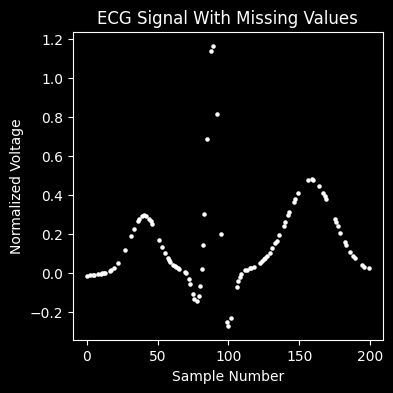

In [6]:
# Component plot of the ecg signal
fig, ax = plt.subplots(1, 1)
component_index = range(0, len(df_ecg['ecgvalues']))
ax.scatter(component_index, df_ecg['ecgvalues'], color = 'white', marker = 'o', s = 5)
ax.set_xlabel('Sample Number')
ax.set_ylabel('Normalized Voltage')
ax.set_title('ECG Signal With Missing Values');

---

Extract the indices corresponding to the missing and known ECG values. For simplicity, assume that the full ECG signal is a 6-vector x with samples 3, 5, and 6 missing as shown below:

$$\begin{align*}
\mathbf{x} &= \begin{bmatrix}x_1\\x_2\\{\color{yellow}{x_3}}\\x_4\\{\color{yellow}{x_5}}\\{\color{yellow}{x_6}}\end{bmatrix} = \begin{bmatrix}x_1\\x_2\\{\color{yellow}{v_1}}\\x_4\\{\color{yellow}{v_2}}\\{\color{yellow}{v_3}}\end{bmatrix}.
\end{align*}$$

---

In [7]:
# Extract the indices corresponding to the missing ECG values
indices_unknown = df_ecg[df_ecg['ecgvalues'].isnull()].index
print(indices_unknown)
# Extract the indices corresponding to the known ECG values
indices_known = df_ecg[~df_ecg['ecgvalues'].isnull()].index
print(indices_known)

Index([  1,   3,   6,   7,   9,  14,  15,  18,  20,  21,  23,  24,  25,  26,
        28,  29,  30,  32,  34,  35,  38,  41,  43,  47,  48,  49,  50,  52,
        54,  56,  60,  66,  67,  68,  71,  74,  77,  84,  86,  87,  90,  91,
        93,  94,  96,  97,  98, 101, 103, 104, 105, 110, 111, 114, 117, 119,
       120, 121, 123, 128, 130, 132, 135, 137, 138, 141, 144, 145, 148, 150,
       151, 152, 153, 154, 155, 157, 158, 161, 162, 163, 165, 166, 170, 171,
       172, 173, 174, 178, 180, 181, 184, 185, 187, 190, 191, 192, 193, 195,
       197, 198],
      dtype='int64')
Index([  0,   2,   4,   5,   8,  10,  11,  12,  13,  16,  17,  19,  22,  27,
        31,  33,  36,  37,  39,  40,  42,  44,  45,  46,  51,  53,  55,  57,
        58,  59,  61,  62,  63,  64,  65,  69,  70,  72,  73,  75,  76,  78,
        79,  80,  81,  82,  83,  85,  88,  89,  92,  95,  99, 100, 102, 106,
       107, 108, 109, 112, 113, 115, 116, 118, 122, 124, 125, 126, 127, 129,
       131, 133, 134, 136, 139, 140, 

---

Build a vector of known ecg_signal values. Using the simple ECG signal example, we get:

$$\mathbf{x}_\text{known} = \begin{bmatrix}x_1\\x_2\\x_4\end{bmatrix}.$$

---

In [8]:
df_ecg[indices_known]

KeyError: "None of [Index([  0,   2,   4,   5,   8,  10,  11,  12,  13,  16,  17,  19,  22,  27,\n        31,  33,  36,  37,  39,  40,  42,  44,  45,  46,  51,  53,  55,  57,\n        58,  59,  61,  62,  63,  64,  65,  69,  70,  72,  73,  75,  76,  78,\n        79,  80,  81,  82,  83,  85,  88,  89,  92,  95,  99, 100, 102, 106,\n       107, 108, 109, 112, 113, 115, 116, 118, 122, 124, 125, 126, 127, 129,\n       131, 133, 134, 136, 139, 140, 142, 143, 146, 147, 149, 156, 159, 160,\n       164, 167, 168, 169, 175, 176, 177, 179, 182, 183, 186, 188, 189, 194,\n       196, 199],\n      dtype='int64')] are in the [columns]"

In [30]:
## Build a vector of known ecg_signal values
x_known = df_ecg.iloc[indices_known]
print(x_known)

     ecgvalues
0    -0.014374
2    -0.012637
4    -0.010812
5    -0.009853
8    -0.006548
..         ...
188   0.085758
189   0.076497
194   0.042017
196   0.033077
199   0.023651

[100 rows x 1 columns]


---

Build the sampling matrices $\mathbf{S}_1$ and $\mathbf{S}_2$ such that

$$\begin{align*}
\underbrace{\begin{bmatrix}?&?&?\\?&?&?\\?&?&?\\?&?&?\\?&?&?\\?&?&?\end{bmatrix}}_{\mathbf{S}_1}\begin{bmatrix}x_1\\x_2\\x_4\end{bmatrix}+\underbrace{\begin{bmatrix}?&?&?\\?&?&?\\?&?&?\\?&?&?\\?&?&?\\?&?&?\end{bmatrix}}_{\mathbf{S}_2}\begin{bmatrix}{\color{yellow}{v_1}}\\{\color{yellow}{v_2}}\\{\color{yellow}{v_3}}\end{bmatrix}=\begin{bmatrix}x_1\\x_2\\{\color{yellow}{v_1}}\\x_4\\{\color{yellow}{v_2}}\\{\color{yellow}{v_3}}\end{bmatrix}.
\end{align*}$$

---

In [10]:
I = np.eye(len(df_ecg))

S1 =I[ :,indices_known]
S2 = I[:,indices_unknown]

---

Build the second-difference matrix $\mathbf{D}$ which for the simple ECG example is

$$\mathbf{D} = \begin{bmatrix}1&-2&1&0&0&0\\0&1&-2&1&0&0\\0&0&1&-2&1&0\\0&0&0&1&-2&1\end{bmatrix}.$$

Note that the shape of $\mathbf{D}$ is $(6-2)\times6 = 4\times6.$

We achieve this by building a $6\times6$-matrix as follows and removing the 1st and last rows:

$$\mathbf{D} = \begin{bmatrix}\color{cyan}{-2}&\color{pink}1&0&0&0&0\\\color{pink}1&\color{cyan}{-2}&\color{pink}1&0&0&0\\0&\color{pink}1&\color{cyan}{-2}&\color{pink}1&0&0\\0&0&\color{pink}1&\color{cyan}{-2}&\color{pink}1&0\\0&0&0&\color{pink}1&\color{cyan}{-2}&\color{pink}1\\0&0&0&0&\color{pink}1&\color{cyan}{-2}\end{bmatrix}.$$


---

In [11]:
a = np.array([1, 1, 1, 1, 1])
np.diag(a,-1)+np.diag(a,1)

array([[0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0]])

In [12]:
## Build the second-difference matrix D for the simple ECG example
a = np.array([1, 1, 1, 1, 1])
b = np.array([-2, -2, -2, -2, -2, 2])
D = np.diag(a,-1)+np.diag(a,1)+np.diag(b)
print(D)
print('D after removing 1st and last rows')
D = D[1:-1,:]
print(D)

[[-2  1  0  0  0  0]
 [ 1 -2  1  0  0  0]
 [ 0  1 -2  1  0  0]
 [ 0  0  1 -2  1  0]
 [ 0  0  0  1 -2  1]
 [ 0  0  0  0  1  2]]
D after removing 1st and last rows
[[ 1 -2  1  0  0  0]
 [ 0  1 -2  1  0  0]
 [ 0  0  1 -2  1  0]
 [ 0  0  0  1 -2  1]]


---

Using the simple ECG example, we will visualize the effect of multiplying a signal vector by the matrix $\mathbf{D}.$

---

In [21]:
np.dot(D,d)

array([ 0., 20., 20., 50., 20., 40.])

D times constant signal a = Da = [0 0 0 0] => ||Da|| = 0.0
D times increasing signal b = Db = [0 0 0 0] => ||Db|| = 0.0
D times rapidly changing signal c = Dc = [ 40 -40  40 -40] => ||Dc|| = 80.0
D times not so rapidly changing signal d = Dd = [ 20   0  10 -60]  => ||Dd|| = 64.03124237432849


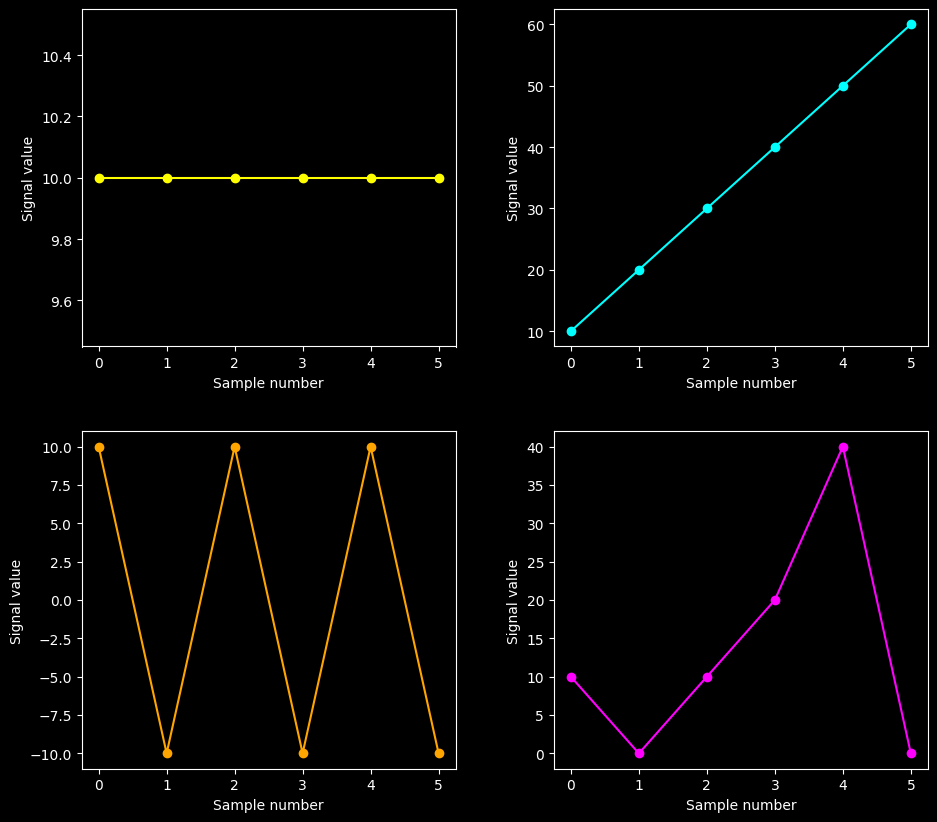

In [14]:
## Using the simple ECG example, we will visualize the effect of multiplying
## a signal vector by the matrix D

a = np.array([10, 10, 10, 10, 10, 10]) # a constant signal
b = np.array([10, 20, 30, 40, 50, 60]) # an increasing signal
c = np.array([10, -10, 10, -10, 10, -10]) # a rapidly changing signal
d = np.array([10, 0, 10, 20, 40, 00]) # a not-so-rapidly changing signal

fig, axes = plt.subplots(2, 2, figsize = (10, 9))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.tight_layout(pad = 4.0)
ax1.plot(np.arange(len(a)), a, color = 'yellow', marker = 'o')
ax1.set_xlabel('Sample number')
ax1.set_ylabel('Signal value')
ax2.plot(np.arange(len(b)), b, color = 'cyan', marker = 'o')
ax2.set_xlabel('Sample number')
ax2.set_ylabel('Signal value')
ax3.plot(np.arange(len(c)), c, color = 'orange', marker = 'o')
ax3.set_xlabel('Sample number')
ax3.set_ylabel('Signal value')
ax4.plot(np.arange(len(d)), d, color = 'magenta', marker = 'o')
ax4.set_xlabel('Sample number')
ax4.set_ylabel('Signal value')

print(f'D times constant signal a = Da = {np.dot(D, a)} => ||Da|| = {np.linalg.norm(np.dot(D, a))}')
print(f'D times increasing signal b = Db = {np.dot(D, b)} => ||Db|| = {np.linalg.norm(np.dot(D, b))}')
print(f'D times rapidly changing signal c = Dc = {np.dot(D, c)} => ||Dc|| = {np.linalg.norm(np.dot(D, c))}')
print(f'D times not so rapidly changing signal d = Dd = {np.dot(D, d)}  => ||Dd|| = {np.linalg.norm(np.dot(D, d))}')

---

Build the second-difference matrix D for the ECG data

---

In [28]:
n=6
a=1*np.ones(n-1)
print(a)
b=-2*np.ones(n)
print(b)
D=np.diag(a,-1)+np.diag(b,0)+np.diag(a,1)
D=D[1:-1,:]
print(D)
D.shape

[1. 1. 1. 1. 1.]
[-2. -2. -2. -2. -2. -2.]
[[ 1. -2.  1.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  1. -2.  1.]]


(4, 6)

In [ ]:
## Build the second-difference matrix D for the ECG data
n = len(df_ecg) # size of the signal
a=1*np.ones(n-1)
b=-2*np.ones(n)
D=np.diag(a,-1)+np.diag(b,0)+np.diag(a,1)
D.shape
D = D[1:-1, :]
D.shape

(198, 200)

---

Solving an inconsitent system of equations using the least squares approach.

Consider solving the system of equations $\mathbf{A}{\color{yellow}{\mathbf{v}}} = \mathbf{b},$ where

$$\mathbf{A} = \begin{bmatrix}1&0&0\\0&1&0\\0&0&1\\0&0&0\end{bmatrix}\ \text{and }\mathbf{b} = \begin{bmatrix}1\\2\\3\\4\end{bmatrix}.$$

Note that there is no solution to this system of equations. We refer to the system as being "inconsistent." The "best" approximation for the solution that we can come up with is

$$\hat{\color{yellow}{\mathbf{v}}} = \begin{bmatrix}1\\2\\3\end{bmatrix}.$$

This solution is best in the sense that $$\mathbf{A}\hat{\color{yellow}{\mathbf{v}}} = \begin{bmatrix}1&0&0\\0&1&0\\0&0&1\\0&0&0\end{bmatrix}\begin{bmatrix}1\\2\\3\end{bmatrix}=\begin{bmatrix}1\\2\\3\\0\end{bmatrix}$$ is close as possible to the right hand side vector $$\mathbf{b} = \begin{bmatrix}1\\2\\3\\4\end{bmatrix}.$$ We see that $$\mathbf{A}\hat{\color{yellow}{\mathbf{v}}}-\mathbf{b}=\begin{bmatrix}1\\2\\3\\0\end{bmatrix}-\begin{bmatrix}1\\2\\3\\4\end{bmatrix}=\begin{bmatrix}0\\0\\0\\-4\end{bmatrix}$$ has most components equal to zeros and therefore has a small norm (magnitude). Therefore, $\hat{\color{yellow}{\mathbf{v}}}$ is called the least squares solution because $\lVert \mathbf{A}\hat{\color{yellow}{\mathbf{v}}}-\mathbf{b}\rVert_2^2$ is the smallest possible value.  

---

In [15]:
## Solving an inconsitent system of equations using the least squares approach
A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0]])
print(A)
b = np.array([1, 2, 3, 4])
print(b)
# Get the least squares solution
vhat = linalg.lstsq(A, b)[0]
print(vhat)

[[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 0]]
[1 2 3 4]
[1. 2. 3.]


In [16]:
linalg.lstsq(A,b)[0]

array([1., 2., 3.])

---

Reconstruct the ECG signal such that it is smooth by solving the following linear least squares problem:

$$\begin{align*}\min_{\color{yellow}{\mathbf{v}}}\left\lVert\mathbf{D}\hat{\mathbf{x}}\right\rVert_2^2 = \min_{\color{yellow}{\mathbf{v}}}\left\lVert\mathbf{D}\left(\mathbf{S}_1\mathbf{x}_\text{known} + \mathbf{S}_2{\color{yellow}{\mathbf{v}}}\right)\right\rVert_2^2 = \min_\mathbf{v}\left\lVert\underbrace{\mathbf{D}\mathbf{S}_1\mathbf{x}_\text{known}}_{=-\mathbf{b}} + \underbrace{\mathbf{D}\mathbf{S}_2}_{=\mathbf{A}}{\color{yellow}{\mathbf{v}}}\right\rVert_2^2.\end{align*}$$

---

In [40]:
## Reconstruct the ECG signal such that it is smooth
A = np.dot(D,S2)
b = -np.dot(D,np.dot(S1,x_known))
vhat = linalg.lstsq(A,b)[0]
#print(v[0].flatten().shape)
df_ecg.loc[indices_unknown, 'ecgvalues'] = vhat.flatten()
print(df_ecg)

     ecgvalues
0    -0.014374
1    -0.013512
2    -0.012637
3    -0.011739
4    -0.010812
..         ...
195   0.037223
196   0.033077
197   0.029577
198   0.026506
199   0.023651

[200 rows x 1 columns]


In [38]:
# Check if there are any missing values
np.mean(df_ecg['ecgvalues'].isnull())*100

np.float64(0.0)

Text(0.5, 1.0, 'ECG Signal With Missing Values Interpolated')

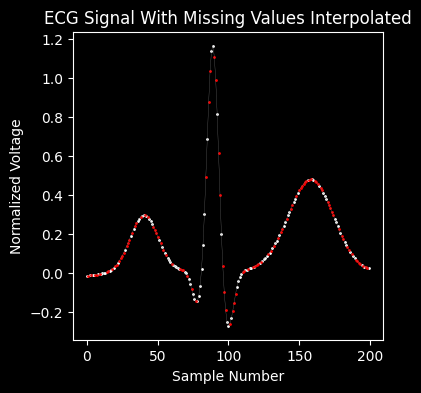

In [39]:
## Component plot of the reconstructed ecg signal
fig, ax = plt.subplots(1, 1)
component_index = np.arange(0, len(df_ecg['ecgvalues']))
ax.scatter(component_index[np.array(indices_known)], df_ecg.loc[indices_known, 'ecgvalues'], color = 'white', s = 1)
ax.scatter(component_index[np.array(indices_unknown)], df_ecg.loc[indices_unknown, 'ecgvalues'], color = 'red', s = 1)
ax.plot(component_index, df_ecg['ecgvalues'], color = 'gray', linewidth = 0.2)
ax.set_xlabel('Sample Number')
ax.set_ylabel('Normalized Voltage')
ax.set_title('ECG Signal With Missing Values Interpolated')